# Extracellular Recording Processing Pipeline

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import neo.io as ni
import neo as n
import zipfile
from neo.io import Spike2IO
import numpy as np
import inspect
import spikeinterface.full as si
import spikeinterface.widgets as sw
from spikeinterface import create_sorting_analyzer
import hdbscan
from probeinterface import generate_linear_probe
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe,plot_probe_group
import probeinterface as pi
import spikeinterface.sortingcomponents as sc
import pandas as pd
from probeinterface import generate_dummy_probe
import seaborn as sns

import scipy.stats as stats
#import spikeinterface.core as si
import spikeinterface.extractors as se
from spikeinterface.postprocessing import compute_principal_components
from spikeinterface.qualitymetrics import (
    compute_snrs,
    compute_firing_rates,
    compute_isi_violations,
    calculate_pc_metrics,
    compute_quality_metrics,
)

## Probe Creation 

In [2]:
probe1 = Probe(ndim=2)

In [3]:
electrode_position1 = [[5.5 * 1000, 2.1 * 1000]]

probe1.set_contacts(positions=electrode_position1, shapes='circle', shape_params={'radius': 10})

probe1.set_contact_ids(['0'])

In [4]:
probe2 = Probe(ndim=2)



In [5]:
electrode_position2 = [[ 6.5 * 1000, 1.6 * 1000]]
probe2.set_contacts(positions=electrode_position2, shapes='circle', shape_params={'radius': 10})
probe2.set_contact_ids(['2'])

In [6]:
probe1.set_device_channel_indices([0])
probe2.set_device_channel_indices([1]) 

In [7]:
probe_group1 = ProbeGroup()


In [8]:
probe_group1.add_probe(probe1)
probe_group1.add_probe(probe2)

## Instantiation, Using Recording Extractor for data extraction 

In [4]:
data_loc = r"D:\GIPSA Labwork Internship\spiekee\Spikeme\sourcedata\520\ieeg\520-06.smr"
data_loc2 = r"D:\GIPSA Labwork Internship\spike_interface_primaries\RAWAT\Spikeme\Spikeme\sourcedata\502\ieeg\502-01.smr"



read_spike2 class is best for .smr file reading. 

In [22]:
full_raw_control = si.read_spike2(data_loc)
full_raw_PD = si.read_spike2(data_loc2)

Extracting gain values to return a scaled recording

In [23]:
gains = full_raw_PD.get_channel_gains()

In [14]:
PDProbbedRecording = full_raw_PD.set_probegroup(probe_group1)

In [15]:
PDProbbedRecording

Spike2RecordingExtractor: 2 channels - 14.8kHz - 1 segments - 15,720,678 samples 
                          1,061.15s (17.69 minutes) - int16 dtype - 59.97 MiB
  file_path: D:\GIPSA Labwork Internship\spike_interface_primaries\RAWAT\Spikeme\Spikeme\sourcedata\502\ieeg\502-01.smr

predefined scale() function for applying gains to the recording

In [16]:
scaled_recording = si.scale(PDProbbedRecording,gain = gains)

In [17]:
scaled_recording

ScaleRecording: 2 channels - 14.8kHz - 1 segments - 15,720,678 samples - 1,061.15s (17.69 minutes) 
                float32 dtype - 119.94 MiB

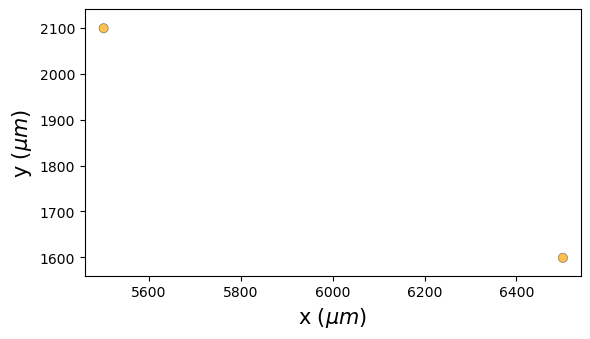

In [18]:
si.plot_probe_map(PDProbbedRecording)
plt.show()

SMR BIDS events extracts the duration of the recording, so that the durations can be used to create frame slices. Frame slices will represent the different conditions of the optogenetic protocol 

In [19]:
def SMR_BIDS_events(filename_in,filename_out):
    smr_file = Spike2IO(filename_in)
    block_struc = smr_file.read_block(block_index=0,load_waveforms=True)
    events_smr = block_struc.segments[0].events
    smr_dict = {"onset":[],"duration":[],"trial_type":[]}
    for event_num in range(0,4):
        smr_dict["onset"].append(events_smr[4].magnitude[event_num])

        if event_num==0:
            smr_dict["duration"].append(events_smr[4].magnitude[1]-events_smr[4].magnitude[0])

        elif 0<event_num<3  :
            smr_dict["duration"].append(events_smr[4].magnitude[event_num]-events_smr[4].magnitude[event_num-1])

        elif event_num==3:
            smr_dict["duration"].append(block_struc.segments[0].t_stop.magnitude-events_smr[4].magnitude[event_num])
                


        
        smr_dict["trial_type"] = ["control","footshock","laser","laser_footshock"]
    
    
    smr_df = pd.DataFrame(smr_dict)
        
    smr_df.to_csv(filename_out)
    
    
    


In [20]:
PD_smr = r"D:\GIPSA Labwork Internship\spike_interface_primaries\RAWAT\Spikeme\Spikeme\sourcedata\502\ieeg\502-01.smr"
smrcsvfile= r"D:\GIPSA Labwork Internship\spiekee\Spikeme\smr_final.csv"

SMR_BIDS_events(control_smr,smrcsvfile)

In [21]:
pd.read_csv(smrcsvfile)

Unnamed: 0       onset    duration       trial_type
0           0    1.060017  353.307825          control
1           1  354.367842  353.307825        footshock
2           2  688.487577  334.119735            laser
3           3  938.327892  275.191900  laser_footshock

Spike interface has frame slice function which slices the recording by taking a start frame and an end frame

In [22]:
def frame_slicing(filename):
    
    #smr_file_m = si.read_spike2(filename)
    events = pd.read_csv(smrcsvfile)
    
    
    
    slices=[]
    for onsets in range(0,5):
          if onsets == 0:
               slices.append(filename.frame_slice(start_frame =filename.time_to_sample_index(time_s=events["onset"][0]) ,end_frame = filename.time_to_sample_index(time_s=events["onset"][1])))
               
          elif onsets==(len(events["onset"])-1):
               slices.append(filename.frame_slice(start_frame =filename.time_to_sample_index(time_s=events["onset"][onsets]) ,end_frame = filename.time_to_sample_index(time_s=filename.get_times()[-1])))
               break
          
          elif 0<onsets<(len(events["onset"])):
              slices.append(filename.frame_slice(start_frame =filename.time_to_sample_index(time_s=events["onset"][onsets]) ,end_frame = filename.time_to_sample_index(time_s=events["onset"][onsets+1])))
          
          
               
    
    
    return slices 

Representation of the footshock artifacts which occured on 3.2085 second

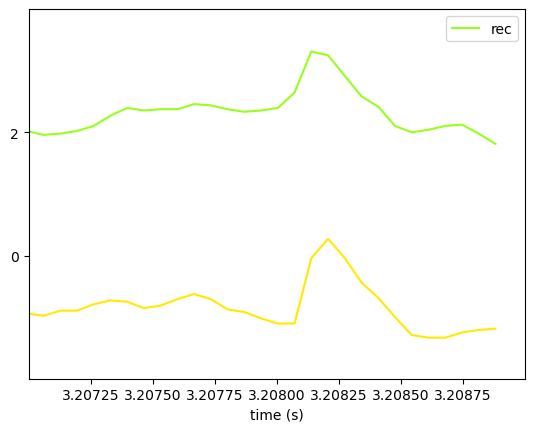

In [23]:
PDProbbedRecording.set_channel_groups(channel_ids=PDProbbedRecording.get_channel_ids(), groups=[0,1])
plot_control = si.plot_traces(PDProbbedRecording, time_range=(3.207,3.209),mode='line',show_channel_ids=True, color_groups= True)

## Preprocessing

In [31]:
Sliced_Recordings_PD=frame_slicing(scaled_recording)

Recording seperated according to conditions  

In [32]:
Control_condition = Sliced_Recordings_PD[0]
Footshock_only_condition= Sliced_Recordings_PD[1]
Optogenetic_only_condition = Sliced_Recordings_PD[2]
Optogenetic_Footshock_condition = Sliced_Recordings_PD[3]



seond order filter applied as mentioned in spyking circus article

In [33]:
filter_kwargs = {"filter_order":2}

filter applied for each recording

In [34]:
recording_control= si.bandpass_filter(Control_condition, freq_min=500, freq_max=6000,**filter_kwargs)
recording_foot= si.bandpass_filter(Footshock_only_condition, freq_min=500, freq_max=6000,**filter_kwargs)
recording_optognetic= si.bandpass_filter(Optogenetic_only_condition, freq_min=500, freq_max=6000,**filter_kwargs)
recording_both= si.bandpass_filter(Optogenetic_Footshock_condition , freq_min=500, freq_max=6000,**filter_kwargs)


common median referencing applied

In [37]:
rec_cmr_control = si.common_reference(recording=recording_control, operator="median", reference="global")
rec_cmr_shock = si.common_reference(recording=recording_foot, operator="median", reference="global")
rec_cmr_laser = si.common_reference(recording=recording_optognetic, operator="median", reference="global")
rec_cmr_both = si.common_reference(recording=recording_both, operator="median", reference="global")

In [38]:
new_params = si.get_default_sorter_params("spykingcircus2")


In [39]:
new_params

{'general': {'ms_before': 2, 'ms_after': 2, 'radius_um': 100},
 'sparsity': {'method': 'ptp', 'threshold': 0.25},
 'filtering': {'freq_min': 150,
  'freq_max': 7000,
  'ftype': 'bessel',
  'filter_order': 2},
 'detection': {'peak_sign': 'neg', 'detect_threshold': 4},
 'selection': {'method': 'uniform',
  'n_peaks_per_channel': 5000,
  'min_n_peaks': 100000,
  'select_per_channel': False,
  'seed': 42},
 'apply_motion_correction': True,
 'motion_correction': {'preset': 'nonrigid_fast_and_accurate'},
 'merging': {'similarity_kwargs': {'method': 'cosine',
   'support': 'union',
   'max_lag_ms': 0.2},
  'correlograms_kwargs': {},
  'auto_merge': {'min_spikes': 10, 'corr_diff_thresh': 0.25}},
 'clustering': {'legacy': True},
 'matching': {'method': 'wobble'},
 'apply_preprocessing': True,
 'matched_filtering': True,
 'cache_preprocessing': {'mode': 'memory',
  'memory_limit': 0.5,
  'delete_cache': True},
 'multi_units_only': False,
 'job_kwargs': {'n_jobs': 0.8},
 'debug': False}

Threshold changed to 7

In [41]:
new_params["detection"]["detect_threshold"] = 7
#new_params["filtering"]["freq_min"] = 500


#new_params["detection"]["radius_um"] = 200

# Spike Sorting for each condition

In [42]:
from pathlib import Path
base_folder = Path(r"D:\sorting_final_final")
slice1_sort_control_new= si.run_sorter(sorter_name = "spykingcircus2", recording=rec_cmr_control, output_folder=base_folder / 'results_spyking_control_new',**new_params)

C:\Users\Akshit\AppData\Local\Temp\ipykernel_23300\2628377225.py:3: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  slice1_sort_control_new= si.run_sorter(sorter_name = "spykingcircus2", recording=rec_cmr_control, output_folder=base_folder / 'results_spyking_control_new',**new_params)
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


We found 2 raw clusters, starting to clean with matching...


d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\baserecordingsnippets.py:264: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


write_memory_recording:   0%|          | 0/1 [00:00<?, ?it/s]

We kept 2 non-duplicated clusters...


In [43]:
from pathlib import Path
base_folder = Path(r"D:\sorting_final_final")
slice1_sort_shocknew= si.run_sorter(sorter_name = "spykingcircus2", recording=rec_cmr_shock, output_folder=base_folder / 'results_spyking_footshocknew',**new_params)

C:\Users\Akshit\AppData\Local\Temp\ipykernel_23300\394759158.py:3: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  slice1_sort_shocknew= si.run_sorter(sorter_name = "spykingcircus2", recording=rec_cmr_shock, output_folder=base_folder / 'results_spyking_footshocknew',**new_params)
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


We found 2 raw clusters, starting to clean with matching...


d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\baserecordingsnippets.py:264: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


write_memory_recording:   0%|          | 0/1 [00:00<?, ?it/s]

We kept 2 non-duplicated clusters...


In [44]:
from pathlib import Path
base_folder = Path(r"D:\sorting_final_final")
slice1_sort_optogeneticnew= si.run_sorter(sorter_name = "spykingcircus2", recording=rec_cmr_laser, output_folder=base_folder / 'results_spyking_optogneticnew',**new_params)

C:\Users\Akshit\AppData\Local\Temp\ipykernel_23300\3991226837.py:3: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  slice1_sort_optogeneticnew= si.run_sorter(sorter_name = "spykingcircus2", recording=rec_cmr_laser, output_folder=base_folder / 'results_spyking_optogneticnew',**new_params)
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


We found 2 raw clusters, starting to clean with matching...


d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\baserecordingsnippets.py:264: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


write_memory_recording:   0%|          | 0/1 [00:00<?, ?it/s]

We kept 2 non-duplicated clusters...


In [45]:
from pathlib import Path
base_folder = Path(r"D:\sorting_final_final")
slice1_sort_bothnew= si.run_sorter(sorter_name = "spykingcircus2", recording=rec_cmr_both, output_folder=base_folder / 'results_spyking_bothnew',**new_params)

C:\Users\Akshit\AppData\Local\Temp\ipykernel_23300\966391253.py:3: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  slice1_sort_bothnew= si.run_sorter(sorter_name = "spykingcircus2", recording=rec_cmr_both, output_folder=base_folder / 'results_spyking_bothnew',**new_params)
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


We found 2 raw clusters, starting to clean with matching...


d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\baserecordingsnippets.py:264: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


write_memory_recording:   0%|          | 0/1 [00:00<?, ?it/s]

We kept 2 non-duplicated clusters...


To read saved file

In [2]:
from pathlib import Path
base_folder = Path(r"D:\sorting_final_final")
extracter_sort_controlnew = si.read_sorter_folder(base_folder / 'results_spyking_control_new')
extracter_sort_shocknew = si.read_sorter_folder(base_folder / 'results_spyking_footshocknew')
extracter_sort_optogennew = si.read_sorter_folder(base_folder / 'results_spyking_optogneticnew')
extracter_sort_bothnew = si.read_sorter_folder(base_folder / 'results_spyking_bothnew')


In [47]:
slice1_sort_control_new
slice1_sort_shocknew
slice1_sort_optogeneticnew
slice1_sort_bothnew

NumpyFolder: 2 units - 1 segments - 14.8kHz

creates soorting anaylzer which has the functionality to compute waveforms, spike amplitudes, template metrics etc.

In [48]:
analyzer_control_new = si.create_sorting_analyzer(sorting=slice1_sort_control_new, recording=rec_cmr_control, folder="D://GIPSA Labwork Internship//analyzer_control_new", format="binary_folder")
analyzer_shock_new = si.create_sorting_analyzer(sorting=slice1_sort_shocknew, recording=rec_cmr_shock, folder="D://GIPSA Labwork Internship//analyzer_shock_new", format="binary_folder")
analyzer_optogenetic_new = si.create_sorting_analyzer(sorting=slice1_sort_optogeneticnew, recording=rec_cmr_laser, folder="D://GIPSA Labwork Internship//analyzer1_optogen_new", format="binary_folder")
analyzer_both_new= si.create_sorting_analyzer(sorting=slice1_sort_bothnew, recording=rec_cmr_both, folder="D://GIPSA Labwork Internship//analyzer1_both_new", format="binary_folder")


d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


estimate_sparsity:   0%|          | 0/354 [00:00<?, ?it/s]

d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\basesorting.py:264: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


estimate_sparsity:   0%|          | 0/335 [00:00<?, ?it/s]

estimate_sparsity:   0%|          | 0/250 [00:00<?, ?it/s]

estimate_sparsity:   0%|          | 0/123 [00:00<?, ?it/s]

read the analyzer saved files

In [4]:
extracted_analyzer_controlnew = si.load_sorting_analyzer("D://GIPSA Labwork Internship//analyzer_control_new", load_extensions=True, format='auto')
extracted_analyzer_shocknew = si.load_sorting_analyzer("D://GIPSA Labwork Internship//analyzer_shock_new", load_extensions=True, format='auto')
extracted_analyzer_optogennew = si.load_sorting_analyzer("D://GIPSA Labwork Internship//analyzer1_optogen_new", load_extensions=True, format='auto')
extracted_analyzer_bothnew = si.load_sorting_analyzer("D://GIPSA Labwork Internship//analyzer1_both_new", load_extensions=True, format='auto')

These compulsory for computing spike amplitudes and running template metrics

In [5]:
# core extensions
extracted_analyzer_controlnew.compute(["random_spikes", "waveforms", "templates", "noise_levels"])
extracted_analyzer_shocknew.compute(["random_spikes", "waveforms", "templates", "noise_levels"])
extracted_analyzer_optogennew.compute(["random_spikes", "waveforms", "templates", "noise_levels"])
extracted_analyzer_bothnew.compute(["random_spikes", "waveforms", "templates", "noise_levels"])



d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


compute_waveforms:   0%|          | 0/354 [00:00<?, ?it/s]

d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


compute_waveforms:   0%|          | 0/335 [00:00<?, ?it/s]

d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


compute_waveforms:   0%|          | 0/250 [00:00<?, ?it/s]

d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


compute_waveforms:   0%|          | 0/123 [00:00<?, ?it/s]

get_extension allows us to load waveforms computed before

In [10]:
wav_control=extracted_analyzer_controlnew.get_extension("waveforms")
wav_shock=extracted_analyzer_shocknew.get_extension("waveforms")
wav_optogen=extracted_analyzer_optogennew.get_extension("waveforms")
wav_both=extracted_analyzer_bothnew.get_extension("waveforms")

The given function is used to load waveforms of each unit separately

In [75]:
wav_control_u0 = wav_control.get_waveforms_one_unit(unit_id = 0)
wav_shock_u0 = wav_shock.get_waveforms_one_unit(unit_id = 0)
wav_optogen_u0 = wav_optogen.get_waveforms_one_unit(unit_id = 0)
wav_both_u0 = wav_both.get_waveforms_one_unit(unit_id = 0)


In [76]:

wav_control_u1 = wav_control.get_waveforms_one_unit(unit_id = 1)
wav_shock_u1 = wav_shock.get_waveforms_one_unit(unit_id = 1)
wav_optogen_u1 = wav_optogen.get_waveforms_one_unit(unit_id = 1)
wav_both_u1 = wav_both.get_waveforms_one_unit(unit_id = 1)

concatenate function is appllied on the numpy arrays of waveforms. The idea is that all of the elements of the array will be the samples from each waveform

In [77]:
samples_control_u0 = np.concatenate(wav_control_u0)
samples_shock_u0 = np.concatenate(wav_shock_u0)
samples_optogen_u0 = np.concatenate(wav_optogen_u0)
samples_both_u0 = np.concatenate(wav_both_u0) 

In [78]:
samples_control_u1 = np.concatenate(wav_control_u1)
samples_shock_u1 = np.concatenate(wav_shock_u1)
samples_optogen_u1 = np.concatenate(wav_optogen_u1)
samples_both_u1 = np.concatenate(wav_both_u1)

Mann whitney u test applied on all the possible combinations 

In [79]:
stats.mannwhitneyu(samples_control_u0, samples_shock_u0)

MannwhitneyuResult(statistic=array([3557830.]), pvalue=array([0.01793798]))

In [80]:
stats.mannwhitneyu(samples_control_u0, samples_optogen_u0)

MannwhitneyuResult(statistic=array([4762617.]), pvalue=array([0.10464567]))

In [81]:
stats.mannwhitneyu(samples_control_u0, samples_both_u0 )

MannwhitneyuResult(statistic=array([2040471.]), pvalue=array([0.75238438]))

In [82]:
stats.mannwhitneyu(samples_shock_u0, samples_optogen_u0)

MannwhitneyuResult(statistic=array([12190693.]), pvalue=array([1.15603616e-11]))

In [83]:
stats.mannwhitneyu(samples_shock_u0, samples_both_u0)

MannwhitneyuResult(statistic=array([5164723.]), pvalue=array([1.6438759e-06]))

In [84]:
stats.mannwhitneyu(samples_optogen_u0, samples_both_u0)

MannwhitneyuResult(statistic=array([7743378.]), pvalue=array([0.07879781]))

For Unit 1

In [85]:
stats.mannwhitneyu(samples_control_u1 , samples_shock_u1)

MannwhitneyuResult(statistic=array([7983011.5]), pvalue=array([0.03467276]))

In [86]:
stats.mannwhitneyu(samples_control_u1, samples_optogen_u1)

MannwhitneyuResult(statistic=array([12531619.5]), pvalue=array([0.01490075]))

In [87]:
stats.mannwhitneyu(samples_control_u1, samples_both_u1)

MannwhitneyuResult(statistic=array([6614118.]), pvalue=array([0.10826413]))

In [88]:
stats.mannwhitneyu(samples_shock_u1, samples_optogen_u1)

MannwhitneyuResult(statistic=array([20914411.5]), pvalue=array([0.78803336]))

In [89]:
stats.mannwhitneyu(samples_shock_u1, samples_both_u1)

MannwhitneyuResult(statistic=array([11110045.]), pvalue=array([0.90344713]))

In [90]:
stats.mannwhitneyu(samples_optogen_u1, samples_both_u1)

MannwhitneyuResult(statistic=array([17364349.5]), pvalue=array([0.93163148]))

SNR vs SC or  unit 0 vs uni1

In [91]:
stats.mannwhitneyu(samples_control_u0, samples_control_u1 )

MannwhitneyuResult(statistic=array([2303267.5]), pvalue=array([0.03335321]))

In [92]:
stats.mannwhitneyu(samples_shock_u0, samples_shock_u1 )

MannwhitneyuResult(statistic=array([10183435.5]), pvalue=array([5.79837809e-12]))

In [93]:
stats.mannwhitneyu(samples_optogen_u0, samples_optogen_u1 )

MannwhitneyuResult(statistic=array([24689170.]), pvalue=array([0.49658672]))

In [94]:
stats.mannwhitneyu(samples_both_u0, samples_both_u1 )

MannwhitneyuResult(statistic=array([5598281.]), pvalue=array([0.52026056]))

The given function computes the spike amplitude. there was no function available for separating the amplitudes of each unit

In [62]:
amps_control = si.compute_spike_amplitudes(extracted_analyzer_controlnew)
amps_shock = si.compute_spike_amplitudes(extracted_analyzer_shocknew)
amps_optogen = si.compute_spike_amplitudes(extracted_analyzer_optogennew)
amps_both = si.compute_spike_amplitudes(extracted_analyzer_bothnew)

d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


spike_amplitudes:   0%|          | 0/354 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/335 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/250 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/123 [00:00<?, ?it/s]

This version represents the combined samples from waveforms of unit 0 and unit 1

In [42]:
samples_control = np.concatenate(wav_control.get_data())
samples_shock = np.concatenate(wav_shock.get_data())
samples_optogen = np.concatenate(wav_optogen.get_data())
samples_both = np.concatenate(wav_both.get_data())


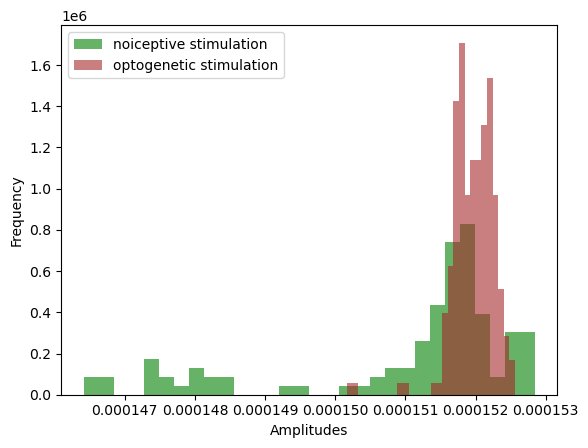

In [69]:
plt.hist(amps_control,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='noiceptive stimulation')
plt.hist(amps_shock,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='optogenetic stimulation')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

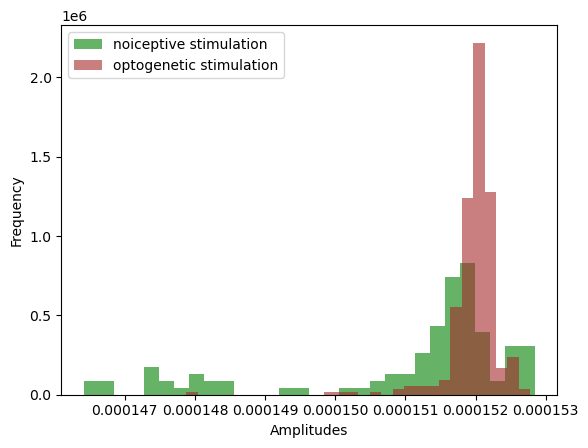

In [70]:
plt.hist(amps_control,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='noiceptive stimulation')
plt.hist(amps_optogen,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='optogenetic stimulation')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

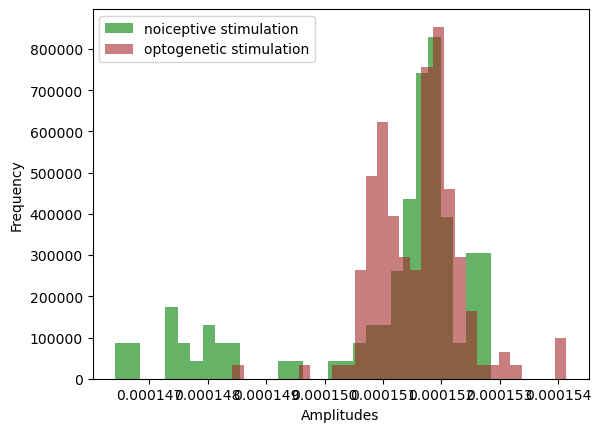

In [71]:
plt.hist(amps_control,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='noiceptive stimulation')
plt.hist(amps_both,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='optogenetic stimulation')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

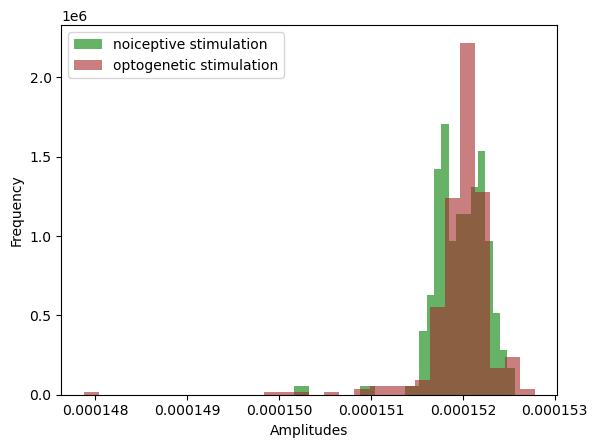

In [72]:
plt.hist(amps_shock,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='noiceptive stimulation')
plt.hist(amps_optogen,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='optogenetic stimulation')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

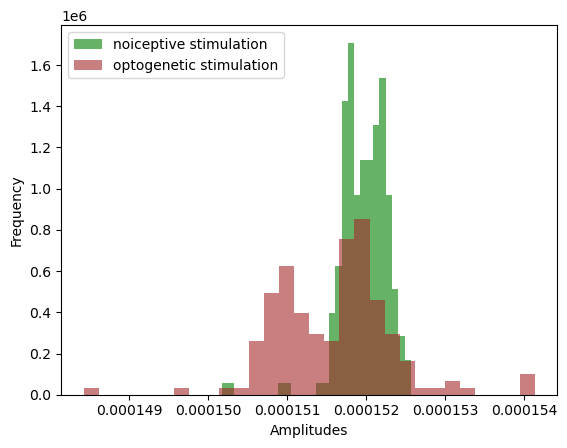

In [73]:
plt.hist(amps_shock,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='noiceptive stimulation')
plt.hist(amps_both,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='optogenetic stimulation')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

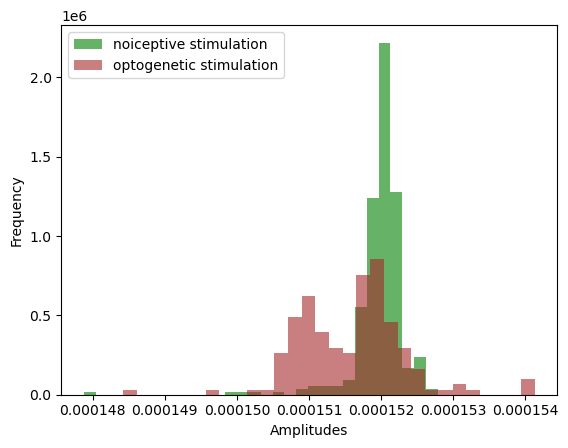

In [74]:
plt.hist(amps_optogen,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='noiceptive stimulation')
plt.hist(amps_both,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='optogenetic stimulation')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

Mann Whitney U test on amplitudes of both units in different conditions

In [63]:
stats.mannwhitneyu(amps_control, amps_shock)

MannwhitneyuResult(statistic=6930.5, pvalue=1.6131608553588647e-09)

In [64]:
stats.mannwhitneyu(amps_control, amps_optogen)

MannwhitneyuResult(statistic=9418.0, pvalue=3.2660502659534263e-13)

In [65]:
stats.mannwhitneyu(amps_control, amps_both)

MannwhitneyuResult(statistic=8029.0, pvalue=0.3909251970146458)

In [66]:
stats.mannwhitneyu(amps_shock, amps_optogen)

MannwhitneyuResult(statistic=33295.0, pvalue=0.08881081292877106)

In [67]:
stats.mannwhitneyu(amps_shock, amps_both)

MannwhitneyuResult(statistic=24606.0, pvalue=3.433228362233512e-11)

In [68]:
stats.mannwhitneyu(amps_optogen, amps_both)

MannwhitneyuResult(statistic=38771.0, pvalue=7.38381756518803e-17)

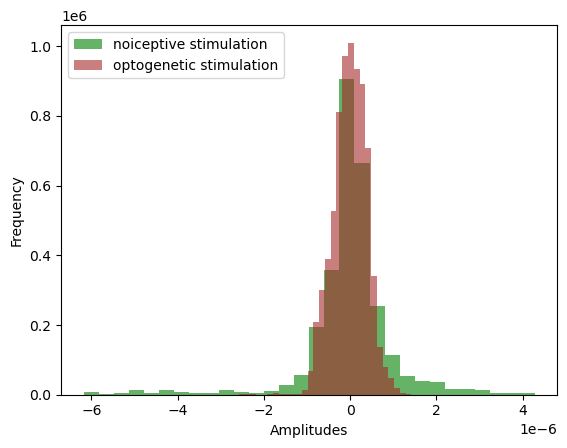

In [49]:
plt.hist(samples_control,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='control condition')
plt.hist(samples_shock,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='opto')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

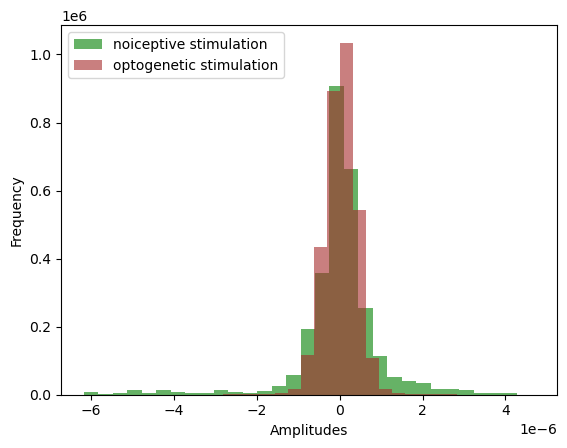

In [50]:
plt.hist(samples_control,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='control')
plt.hist(samples_optogen,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

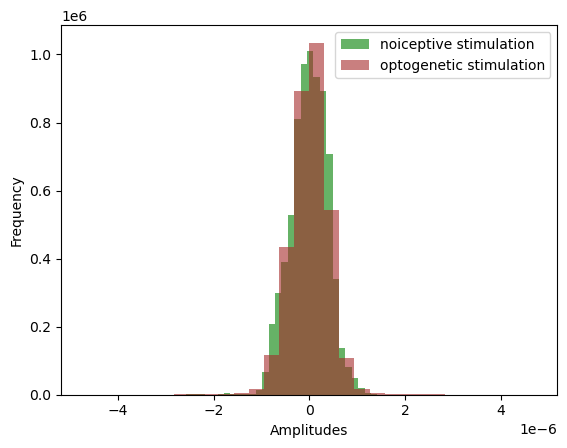

In [51]:
plt.hist(samples_shock,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='noiceptive stimulation')
plt.hist(samples_optogen,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='optogenetic stimulation')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

In [52]:
plt.hist(samples_shock,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='noiceptive stimulation')
plt.hist(samples_both,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='optogenetic stimulation')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

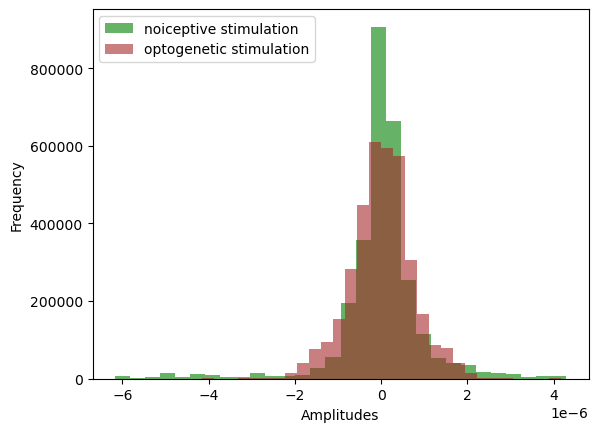

In [53]:
plt.hist(samples_control,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='noiceptive stimulation')
plt.hist(samples_both,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='optogenetic stimulation')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

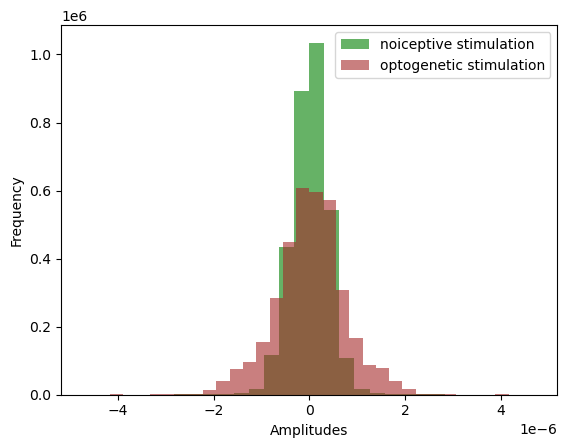

In [54]:
plt.hist(samples_optogen,bins=30,color='green',histtype='stepfilled',density=True,alpha=0.6,label='noiceptive stimulation')
plt.hist(samples_both,bins=30,color ='brown', histtype='stepfilled',density=True,alpha=0.6,label='optogenetic stimulation')
plt.xlabel("Amplitudes")
plt.ylabel("Frequency")
plt.legend()

In [55]:
stats.mannwhitneyu(samples_control, samples_shock)

MannwhitneyuResult(statistic=array([22662365.5]), pvalue=array([6.79157638e-05]))

In [44]:
stats.mannwhitneyu(samples_control, samples_optogen)

MannwhitneyuResult(statistic=array([33182800.5]), pvalue=array([0.1701438]))

In [45]:
stats.mannwhitneyu(samples_control, samples_both)

MannwhitneyuResult(statistic=array([15946746.]), pvalue=array([0.493014]))

In [46]:
stats.mannwhitneyu(samples_shock, samples_optogen)

MannwhitneyuResult(statistic=array([65144432.]), pvalue=array([2.40592256e-05]))

In [47]:
stats.mannwhitneyu(samples_shock, samples_both)

MannwhitneyuResult(statistic=array([31463026.]), pvalue=array([0.00028826]))

In [48]:
stats.mannwhitneyu(samples_optogen, samples_both)

MannwhitneyuResult(statistic=array([48514948.]), pvalue=array([0.28199191]))

Quality metrics

In [13]:
metric_names=['firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']

spy_metrics_control = si.compute_quality_metrics(extracted_analyzer_controlnew, metric_names=metric_names)

d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:902: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


In [14]:
spy_metrics_control

amplitude_cutoff  firing_rate  isi_violations_ratio  isi_violations_count  \
0               NaN     0.104725            774.231903                   9.0   
1               NaN     0.198128             48.069092                   2.0   

   presence_ratio        snr  
0             1.0  14.909297  
1             1.0  14.248619

In [15]:
metric_names=['firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']

spy_metrics_shock = si.compute_quality_metrics(extracted_analyzer_shocknew, metric_names=metric_names)

d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:902: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


In [16]:
spy_metrics_shock

amplitude_cutoff  firing_rate  isi_violations_ratio  isi_violations_count  \
0               NaN     0.299294             11.137325                   1.0   
1               NaN     0.359153              0.000000                   0.0   

   presence_ratio       snr  
0             1.0  5.731802  
1             1.0  6.130104

In [17]:
metric_names=['firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']

spy_metrics_laser = si.compute_quality_metrics(extracted_analyzer_optogennew, metric_names=metric_names)

d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:902: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


In [18]:
spy_metrics_laser

amplitude_cutoff  firing_rate  isi_violations_ratio  isi_violations_count  \
0               NaN     0.572366              4.072576                   1.0   
1               NaN     0.752481              7.068818                   3.0   

   presence_ratio       snr  
0             1.0  4.984987  
1             1.0  5.968761

In [58]:
metric_names=['firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']

spy_metrics_both = si.compute_quality_metrics(extracted_analyzer_bothnew, metric_names=metric_names)

d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(
d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:902: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


## Templates 

In [25]:
unit_ids = extracter_sort_controlnew.unit_ids

sw.plot_unit_templates(extracted_analyzer_controlnew, unit_ids=unit_ids, ncols=5, figsize=(16, 8),scale=gains[0])

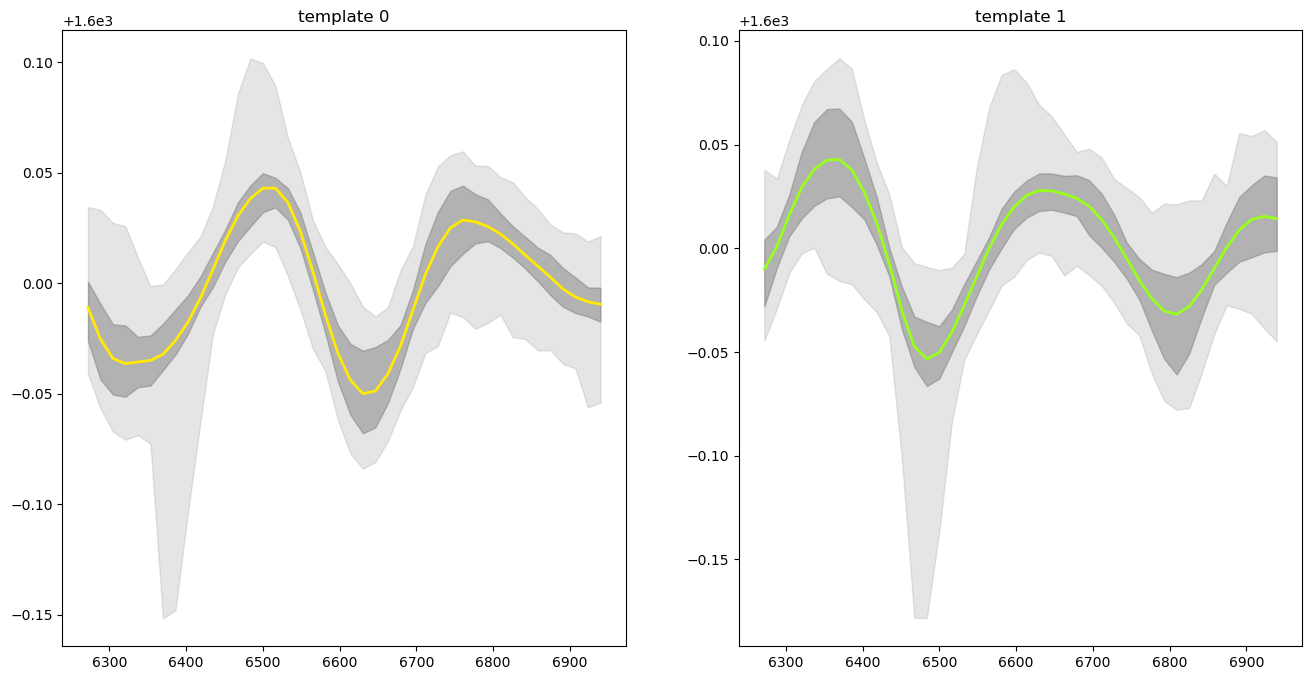

In [24]:
unit_ids = extracter_sort_shocknew.unit_ids

sw.plot_unit_templates(extracted_analyzer_shocknew, unit_ids=unit_ids, ncols=5, figsize=(16, 8),scale=gains[0])

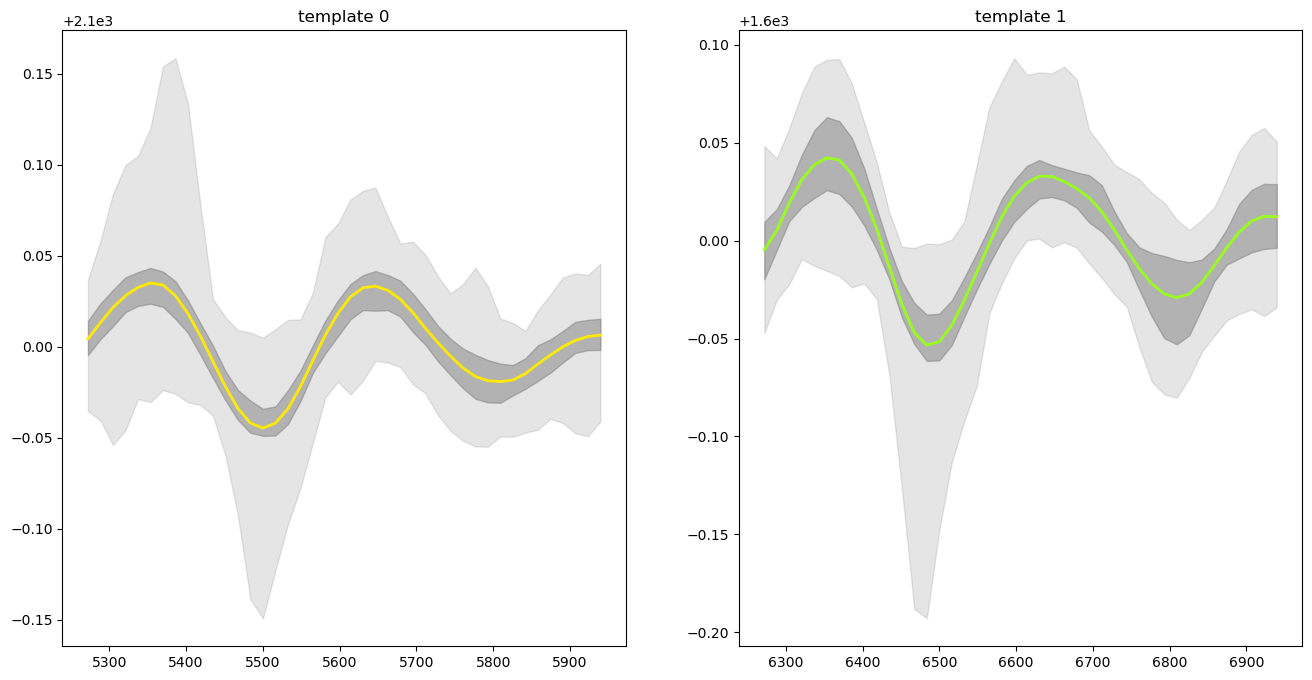

In [26]:
unit_ids = extracter_sort_optogennew.unit_ids

sw.plot_unit_templates(extracted_analyzer_optogennew, unit_ids=unit_ids, ncols=5, figsize=(16, 8),scale=gains[0])

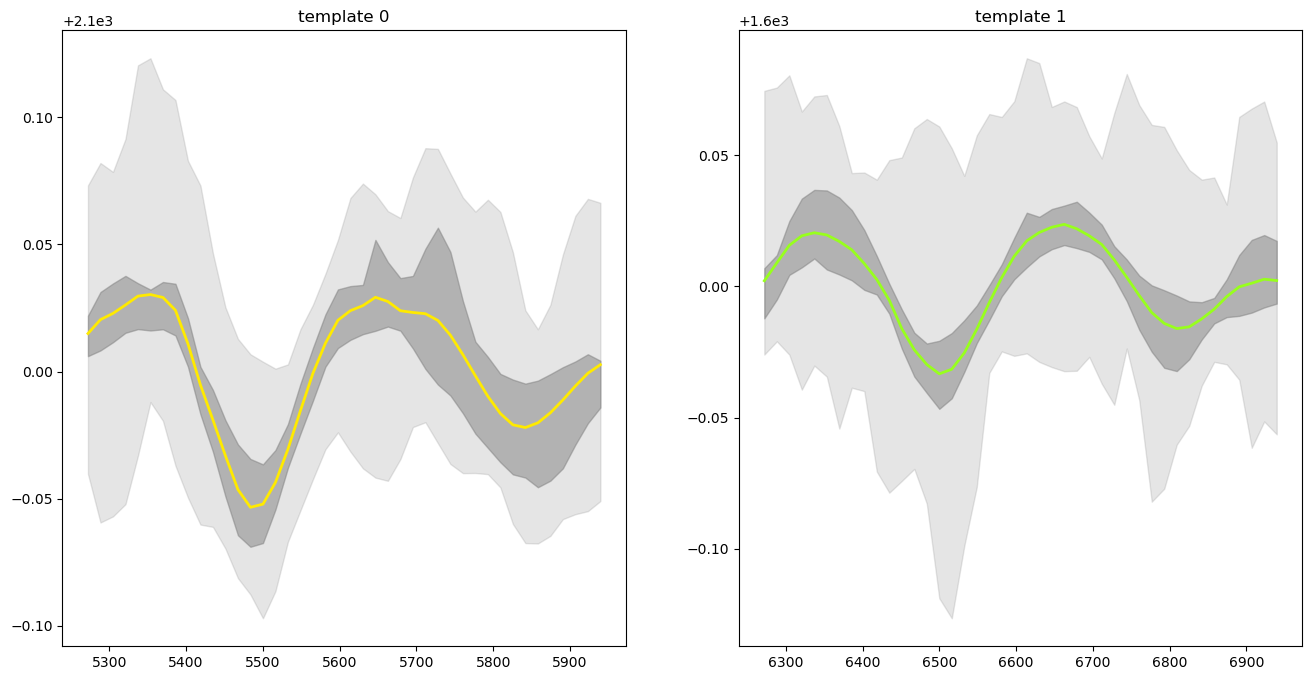

In [27]:
unit_ids = extracter_sort_bothnew.unit_ids

sw.plot_unit_templates(extracted_analyzer_bothnew, unit_ids=unit_ids, ncols=5, figsize=(16, 8),scale=gains[0])

In [63]:
amps_control = si.compute_spike_amplitudes(extracted_analyzer_controlnew)

d:\Anacondanew1\envs\scientificprogramming\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


spike_amplitudes:   0%|          | 0/354 [00:00<?, ?it/s]

# amplitude postion and hists

In [64]:
sw.plot_amplitudes(extracted_analyzer_controlnew, plot_histograms=True, figsize=(12, 8),unit_ids=[0,1])

In [65]:
amps_shock = si.compute_spike_amplitudes(extracted_analyzer_shocknew)

spike_amplitudes:   0%|          | 0/335 [00:00<?, ?it/s]

In [66]:
sw.plot_amplitudes(extracted_analyzer_shocknew, plot_histograms=True, figsize=(12, 8))

In [67]:
amps_optogen = si.compute_spike_amplitudes(extracted_analyzer_optogennew)

spike_amplitudes:   0%|          | 0/250 [00:00<?, ?it/s]

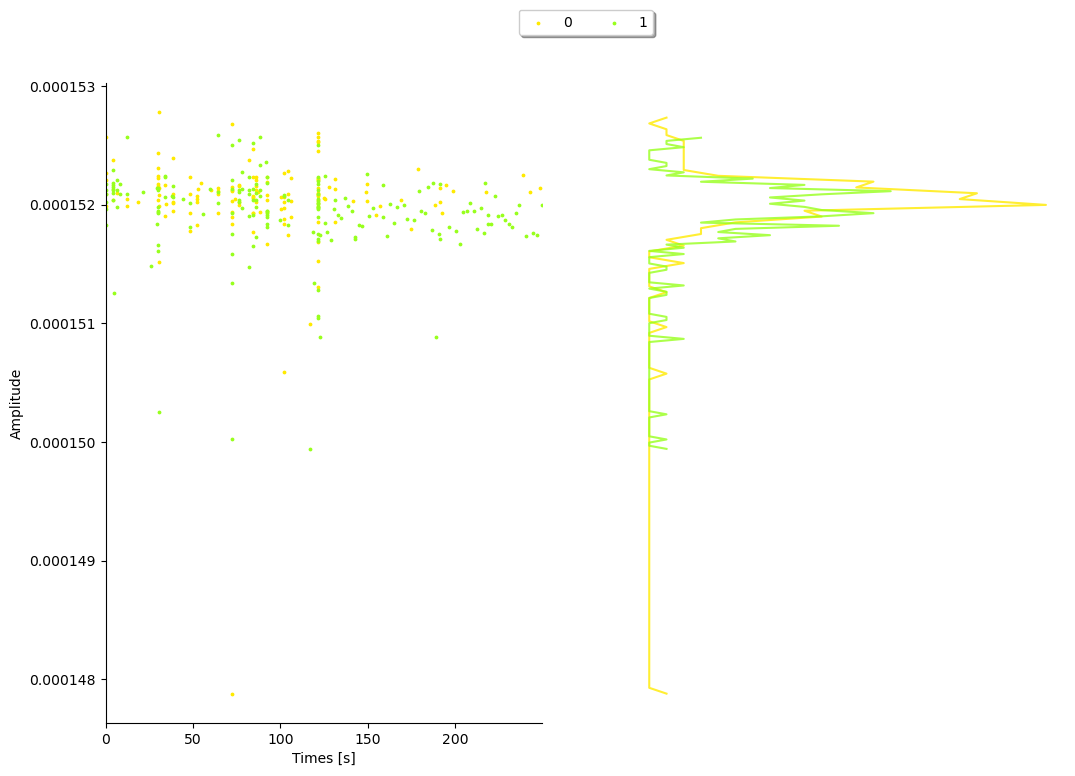

In [68]:
sw.plot_amplitudes(extracted_analyzer_optogennew, plot_histograms=True, figsize=(12, 8))

In [69]:
amps_both = si.compute_spike_amplitudes(extracted_analyzer_bothnew)

spike_amplitudes:   0%|          | 0/123 [00:00<?, ?it/s]

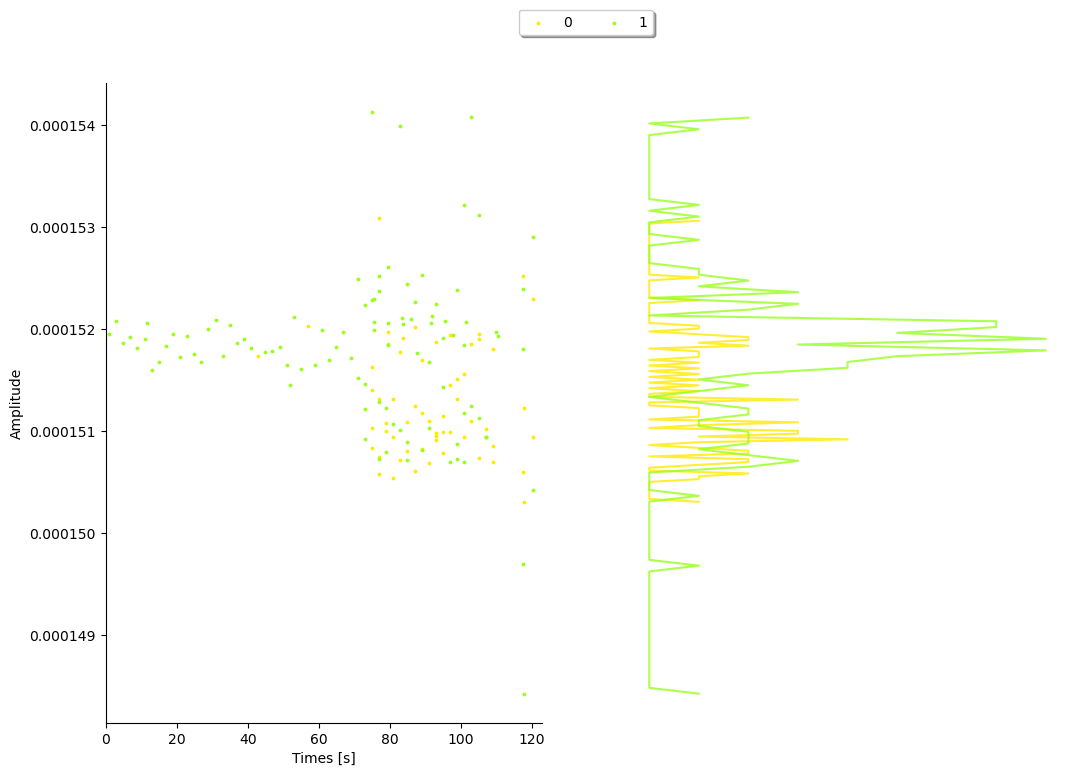

In [70]:
sw.plot_amplitudes(extracted_analyzer_bothnew, plot_histograms=True, figsize=(12, 8))

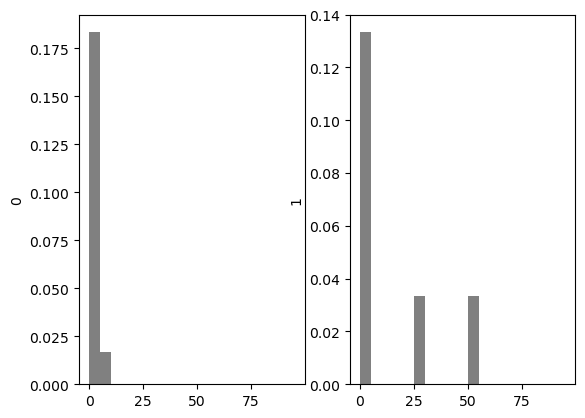

In [71]:
sw.plot_isi_distribution(extracter_sort_controlnew, unit_ids=[0,1], window_ms=100.0, bin_ms=5.0)

In [ ]:
def SMR_BIDS_events(filename_in, filename_out):
    smr_file = Spike2IO(filename_in)
    full_raw_PD = smr_file.read_block() 
    events = smr_file.raw_annotations["blocks"][0]["segments"][0]["events"]

    
    onsets = []
    trial_types = []
    durations = []

    
    for index in range(len(events)):
        
        stamps = smr_file.get_event_timestamps(block_index=0, seg_index=0, event_channel_index=index, t_start=0, t_stop=full_raw_PD.segments[0].analogsignals[0].times[-1])[0]
        rescaled_stamps = smr_file.rescale_event_timestamp(stamps)
        
        
        trial_type = events[index]['name']  

        
        onsets.extend(rescaled_stamps)
        trial_types.extend([trial_type] * len(rescaled_stamps))

        
        durations.extend([0] * len(rescaled_stamps))  

    
    smr_df = pd.DataFrame({
        'onset': onsets,
        'trial_type': trial_types,
        'duration': durations
    })

    
    smr_df.to_csv(filename_out, index=False)

In [ ]:
PD_smr = r"D:\GIPSA Labwork Internship\spiekee\Spikeme\sourcedata\502\ieeg\502-01.smr"
smrcsvfilePD3= r"D:\GIPSA Labwork Internship\spiekee\Spikeme\smrPD_df_new24.csv"

SMR_BIDS_events(PD_smr,smrcsvfilePD3)

TSV file created: D:\GIPSA Labwork Internship\spiekee\Spikeme\smrPD_df_new24.csv


onset  duration trial_type
0          3.208062         0   footshoc
1          5.208062         0   footshoc
2          7.208062         0   footshoc
3          9.208062         0   footshoc
4         11.208062         0   footshoc
...             ...       ...        ...
199220  1047.235047         0      Laser
199221     3.205302         0   Keyboard
199222   295.724720         0   Keyboard
199223   557.892422         0   Keyboard
199224   809.231712         0   Keyboard

[199225 rows x 3 columns]

In [5]:
smr_file = Spike2IO(data_loc2)
block_struc = smr_file.read_block(block_index=0,load_waveforms=True)
events_smr = block_struc.segments[0].events

In [9]:
events_smr[0].name

'footshoc'

In [12]:
event_li = []
for i in events_smr:
    event_li.append(i)


In [54]:
event_dict={}


for i in range(len(events_smr)):
    if events_smr[i].name not in event_dict:
        event_dict.update({events_smr[i].name:pd.Series(events_smr[i].magnitude)})


In [63]:
eve = pd.DataFrame(data =event_dict)

In [64]:
eve["Keyboard"]

0           3.205302
1         295.724720
2         557.892422
3         809.231712
4                NaN
             ...    
159502           NaN
159503           NaN
159504           NaN
159505           NaN
159506           NaN
Name: Keyboard, Length: 159507, dtype: float64

In [2]:
def Tru_SMR_BIDS_events(inputfileloc,outputfileloc):
    smr_file = Spike2IO(inputfileloc)
    block_struc = smr_file.read_block(block_index=0,load_waveforms=True)
    events_smr = block_struc.segments[0].events

    event_dict={}


    for i in range(len(events_smr)):
        if events_smr[i].name not in event_dict:
            event_dict.update({events_smr[i].name:pd.Series(events_smr[i].magnitude)})

    events_csv= pd.DataFrame(data =event_dict)
    events_csv.to_csv(outputfileloc)

    

In [3]:
PD_smr = r"D:\GIPSA Labwork Internship\spiekee\Spikeme\sourcedata\502\ieeg\502-01.smr"
smrcsvfilePD= r"D:\GIPSA Labwork Internship\spiekee\Spikeme\smrPD_df_sept.csv"

Tru_SMR_BIDS_events(PD_smr,smrcsvfilePD)

In [5]:
events = pd.read_csv(smrcsvfilePD)

In [6]:
events["Laser"][0:10]

0    295.729728
1    297.729728
2    299.729728
3    301.729728
4    303.729728
5    305.729728
6    307.729728
7    309.729728
8    311.729728
9    313.729728
Name: Laser, dtype: float64